In [61]:
%matplotlib inline

import numpy as np
import keras
import matplotlib.pyplot as plt
import pysam
import argparse
import h5py
from array import array
import datetime
        
from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense
from keras.models import Model, load_model

In [2]:
#### Filepaths
grch38 = "/seq/references/Homo_sapiens_assembly38/v0/Homo_sapiens_assembly38.fasta"
hg19="/seq/references/Homo_sapiens_assembly19/v1/Homo_sapiens_assembly19.fasta"

CHM = "/seq/picard_aggregation/G94794/CHMI_CHMI3_WGS1/current/CHMI_CHMI3_WGS1.bam"
cram = "/dsde/data/datasets/SnapShotExperiment2015/CEUTrio/Alignments/G94982.NA12878/NA12878.cram"

input_type = "bam"
read_flag = "rc" if input_type == "cram" else "rb"

samfile = pysam.AlignmentFile(CHM, read_flag, reference_filename = hg19)

tr_file_name="/dsde/data/deep/takutoencoder/x_tr.npy"
test_file_name="/dsde/data/deep/takutoencoder/x_test.npy"

In [3]:
#### Set parameters
p_sampling = 0.5
num_tr_examples = int(1e6)
num_test_examples = int(1e4)
read_length = 151

In [4]:
#### Helper Functions

def qc_read(read):
    ''' Given a read decide whether it's a good read '''
    read_group = read.get_tag('RG')
    if 'artificial' in read_group.lower():
        return False
    elif not read.is_proper_pair or not read.is_paired:
        return False
    elif read.is_duplicate or read.is_secondary or read.is_supplementary or read.is_qcfail or read.is_unmapped:
        return False
    
    return True

In [5]:
#### Training
contig = "20"
X_tr = np.zeros((num_tr_examples, read_length))
X_test = np.zeros((num_test_examples, read_length))
i=0
j=0

for read in samfile.fetch(contig):
    if i == num_tr_examples + num_test_examples:
        break;
    
    # QC the reads
    if not qc_read(read):
        continue  

    # randomly sample from among the good reads
    dice = np.random.rand()
    if dice > p_sampling:
        continue    
        
    bqs = np.array(list(reversed(read.query_qualities))) if read.is_reverse else np.array(read.query_qualities)
    if (i < num_tr_examples):
        X_tr[i] = bqs
        i += 1
        continue
    else: 
        X_test[j] = bqs
        j += 1
        i += 1

np.save(tr_file_name, X_tr)
np.save(test_file_name, X_test)

In [13]:
print(X_tr[0])
print(num_tr_examples-1000)
print(X_tr[num_tr_examples-1])
print(X_tr.shape)

[ 27.  29.  24.  28.  29.  28.  29.  28.  28.  28.  27.  27.  27.  27.  28.
  28.  27.  28.  27.  28.  28.  28.  26.  28.  28.  20.  18.  21.  24.  12.
  27.  19.  27.  26.  12.  13.  16.  19.  27.  28.  17.  20.  29.  23.  29.
  29.  26.  29.  28.  29.  29.  29.  30.  29.  30.  29.  28.  29.  20.  26.
  29.  26.  29.  29.  28.  29.  21.  27.  29.  29.  29.  29.  29.  25.  16.
  21.  30.  18.  28.   4.  14.  28.  15.  24.  24.  23.  30.  30.  24.  30.
  30.  30.  29.  30.  17.  28.  24.  27.  26.  26.  28.  31.  30.  29.  25.
  31.  30.  29.  29.  24.  29.  29.  15.  27.  13.  23.  15.  29.   9.   9.
  14.  15.   6.  15.  23.  28.   8.  29.  27.  23.  14.  23.  24.  25.  26.
  14.  26.   6.  32.  29.  26.  29.  30.  30.  22.  30.   2.   2.   2.   2.
   2.]
999000
[ 29.  31.  28.  28.  29.  30.  28.  27.  28.  28.  28.  27.  28.  28.  28.
  28.  27.  28.  28.  28.  27.  28.  28.  27.  28.  27.  27.  28.  27.  28.
  27.  28.  28.  28.  27.  27.  28.  28.  28.  28.  28.  28.  28.  27.  27

In [5]:
# if the test data has been created already, start here
X_tr = np.load(tr_file_name)
X_test = np.load(test_file_name)

In [14]:
# take the sample code from https://blog.keras.io/building-autoencoders-in-keras.html

# this is the size of our encoded representations
encoding_dim = 32

input_qualities = Input(shape=(read_length,))
encoded = Dense(encoding_dim, activation='relu')(input_qualities)
decoded = Dense(read_length, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_qualities, decoded)

In [15]:
# separate encoder model
encoder = Model(input_qualities, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [16]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [22]:
autoencoder.fit(X_tr, X_tr,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 1000000 samples, validate on 10000 samples
Epoch 1/10
1000000/1000000 [==============================] - 7s 7us/step - loss: 12.8309 - val_loss: 11.6837
Epoch 2/10
1000000/1000000 [==============================] - 7s 7us/step - loss: 12.7181 - val_loss: 11.6031
Epoch 3/10
1000000/1000000 [==============================] - 7s 7us/step - loss: 12.6790 - val_loss: 12.6225
Epoch 4/10
1000000/1000000 [==============================] - 7s 7us/step - loss: 12.8607 - val_loss: 11.4981
Epoch 5/10
1000000/1000000 [==============================] - 7s 7us/step - loss: 12.9138 - val_loss: 11.8626
Epoch 6/10
1000000/1000000 [==============================] - 7s 7us/step - loss: 12.9103 - val_loss: 11.3582
Epoch 7/10
1000000/1000000 [==============================] - 7s 7us/step - loss: 12.8829 - val_loss: 12.1126
Epoch 8/10
1000000/1000000 [==============================] - 7s 7us/step - loss: 12.7368 - val_loss: 11.5486
Epoch 9/10
1000000/1000000 [==============================] - 9s 9us

In [25]:
# model_path = "/Users/tsato/workspace/dsde-deep-learning/takutoencoder/chm_hg19_vanilla.h5"
model_path = "/humgen/gsa-hpprojects/dev/tsato/dsde-deep-learning/takutoencoder/models/chm_hg19_vanilla.h5"
autoencoder.save(model_path)

In [14]:
autoencoder.summary()
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 151)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4864      
_________________________________________________________________
dense_2 (Dense)              (None, 151)               4983      
Total params: 9,847
Trainable params: 9,847
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 151)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4864      
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
______

Text(0.5,0.98,'BLUE: AFTER\nRED: BEFORE')

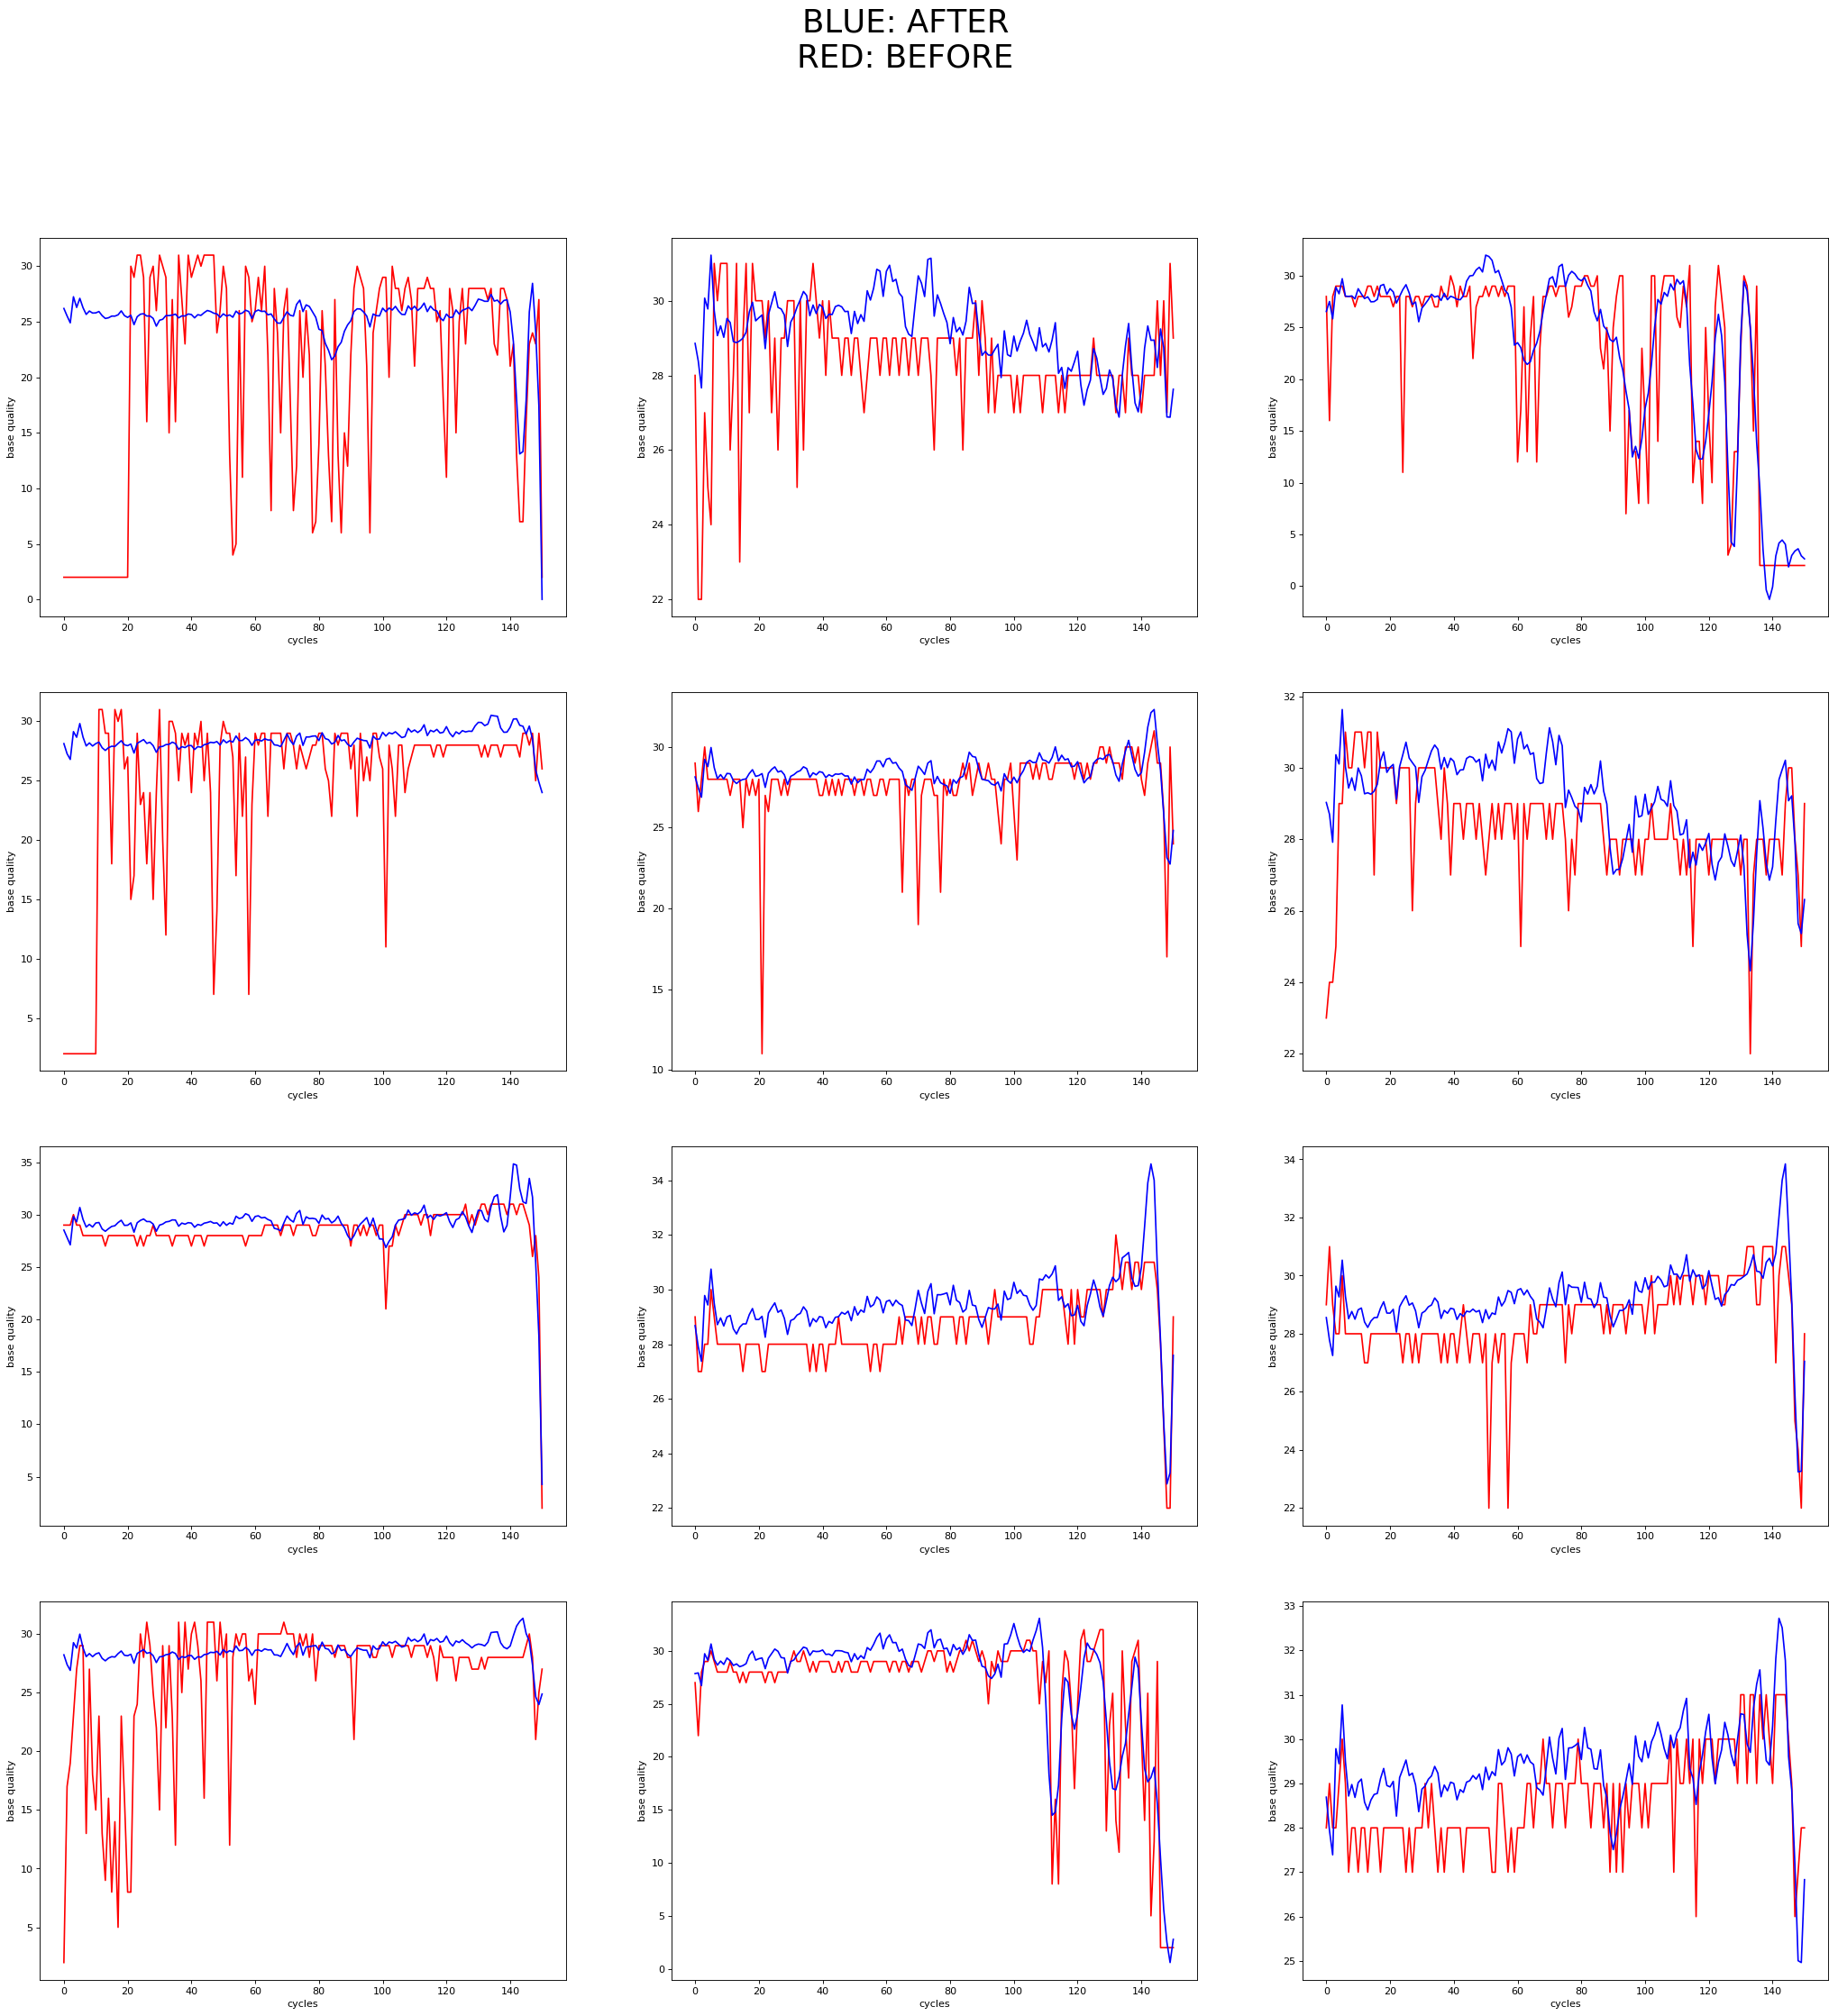

In [58]:
#### Plot what the model learned

N_plot = 300
X = np.zeros((N_plot, read_length))
Y = np.zeros((N_plot, read_length))
i = 0
start_pos = int(30e6) # advance enough reads so we don't reuse same data as training 
for read in samfile.fetch(contig):
    if (i >= N_plot):
        break
    # must change from (151,) to (1, 151)...there has got to be a better way?
    orig_bqs = np.reshape(np.array(read.query_qualities), (1, read_length))
    new_bqs = autoencoder.predict(orig_bqs)
    X[i] = orig_bqs
    Y[i] = new_bqs
    i += 1
    
plt.figure(figsize=(32,32), dpi=80)
num_rows = 4
num_columns = 3
num_samples = num_rows * num_columns
for i in np.arange(1, num_samples+1):
    j = np.random.randint(0, N_plot)
    plt.subplot(num_rows, num_columns, i)
    plt.plot(np.arange(read_length), X[j, :], 'r-')
    plt.plot(np.arange(read_length), Y[j, :], 'b-')
    plt.xlabel("cycles")
    plt.ylabel("base quality")
plt.suptitle("BLUE: AFTER\nRED: BEFORE", fontsize=32)

In [11]:
# If the model has been created already just load it from file
autoencoder = load_model(model_path)

In [67]:
#### WRITE RECALIBRATED TO A CRAM FILE

import time

start = time.time()
print(start)

# compress and write a new sam file
filetype = "sam"
flag = "wb" if filetype == "bam" else "w"
new_samfile_path = "/dsde/data/deep/takutoencoder/output/CHM-after-compression-chr22." + filetype
new_samfile = pysam.AlignmentFile(new_samfile_path, flag, template=samfile, reference_filename = hg19)
overwrite = True
contig = "22"

i = 0
for read in samfile.fetch(contig):
    if qc_read(read):  
        orig_bqs = np.reshape(np.array(read.query_qualities), (1, read_length))
        new_bqs = autoencoder.predict(orig_bqs).reshape(151).astype(int).clip(min = 2)
        if overwrite:
            read.query_qualities = array('b', new_bqs)
        else: 
            read.set_tag("NQ", array('b', new_bqs))
        i += 1
    new_samfile.write(read)

end = time.time()
print(end - start)
print(datetime.datetime.now())

1536338584.6951647
2422.7283997535706
2018-09-07 13:23:27.423792


In [ ]:
# THINK OF A DIFFERENT MODEL